
<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150> <br>
<font color=0F5298 size=7>
Artificial Intelligence <br>
<font color=2565AE size=5>
Computer Engineering Department <br>
Spring 2024<br>
<font color=3C99D size=5>
Practical Assignment 1 - Local Search <br>
<font color=696880 size=4>
Ali Aghayari


____

# Personal Data

In [1]:
# Set your student number
student_number = '401106696'
Name = 'Keyhan'
Last_Name = 'Hodaei'

# Rules

<font color=red>
Please run all the cells.
</font>

# Libraries

In [2]:
!pip install tsp_solver2

You should consider upgrading via the 'C:\Users\RSKALA\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [3]:
# import libraries here
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import time
import itertools
from tsp_solver.greedy import solve_tsp
from timeit import default_timer as timer
random.seed(3)


# Q1: TSP problem

## Problem Definition

Consider the Euclidean  [Traveling Salesperson Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem):</br>
- In this problem, we are considering a country with n cities that are randomly placed; our country is a 1000 by 1000 square; we want to find the shortest tour for this country using their coordinates.
- A tour is a cycle that passes each city precisely one time.
- In this notebook we will develop some solutions to the problem, and more generally show how to think about solving a problem like this.



## Problem Representation (20 Points)

 We want to create our problem structure and present some valuable methods in this part.
 - init: choose your problem structure and create the variables accordingly.
 - distance: take two cities and return the distance between them.
 - tour length: get a tour and return the length of the given tour.
 - The shortest tour: get a set of tours and return the shortest one.
 - plot tour: get a tour and plot tour of the country.
 - nearest_neighbor: get a semi-tour and return to the nearest city to the last element you have yet to visit.

In [4]:
class TSP:

    def __init__(self, num_cities, cities = None):
        # if cities is None --> create randomly placed cities with respect to num_cities
        # else --> use the given data
        # city axis values can be from 0 to 1000
        self.num_cities = num_cities
        if cities is not None:
            self.cities = cities
        else:
            self.cities = [(random.randint(0, 1000), random.randint(0, 1000)) for _ in range(num_cities)]
        self.distances = [[self.distance(i, j) for j in range(num_cities)] for i in range(num_cities)]
    
    
    def distance(self, A, B):
        # returnS distance between city with index/number A and B in cities array
        return math.sqrt((self.cities[A][0]-self.cities[B][0])**2 + (self.cities[A][1]-self.cities[B][1])**2)
    
    
    def tour_length(self, tour):
        # gets the list of cities and returns the tour length
        length = 0
        for i in range(len(tour)-1):
            length += self.distance(tour[i], tour[i+1])
        length += self.distance(tour[0], tour[-1])
        return length
    
    
    def shortest_tour(self, tours):
        # gets a list of tours and returns : shortest_tour, shortest_length
        shortest_length, shortest_tour = float('inf'), None
        for tour in tours:
            length = self.tour_length(tour)
            if length < shortest_length:
                shortest_length, shortest_tour = length, tour
        return shortest_tour, shortest_length
        
    
    def plot_tour(self, tour):
        x, y = [], []
        for city in tour:
            x.append(self.cities[city][0])
            y.append(self.cities[city][1])
        x.append(self.cities[tour[0]][0])
        y.append(self.cities[tour[0]][1])
        plt.plot(x, y, color='blue', marker='o')
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.title('Tour')
        plt.show()
        
    
    def nearest_neighbor(self, A, cities, count = None):
        if count is None:
            shortest_dist, nearest_neighbor = float('inf'), None
            for city in cities:
                if city != A:
                    dist = self.distance(A, city)
                    if dist < shortest_dist:
                        shortest_dist, nearest_neighbor = dist, city
            return nearest_neighbor
        else:
            nearest_dists, nearest_neighbors = [], []
            for city in cities:
                if city != A:
                    dist = self.distance(A, city)
                    if len(nearest_dists) < count:
                        nearest_neighbors.append(city)
                        nearest_dists.append(dist)
                    else:
                        max_dist = max(nearest_dists)
                        if dist < max_dist:
                            idx = max_dist.index(max_dist)
                            nearest_dists[idx], nearest_neighbors[idx] = dist, city
            return nearest_neighbors

## Brute Force (5 Points)

Let's start with an algorithm that is guaranteed to solve the problem (although it is inefficient for large sets of cities) </br>
we can achieve this by generating all possible tours of the cities and choosing the shortest tour (the one with minimum tour length).

In [5]:
def alltours_tsp(tsp):
    # generates all possible tours and returns the shortest tour
    tours = []
    start_city = 0
    permutations = itertools.permutations(list(range(1, tsp.num_cities)))
    for permutation in permutations:
        tour = [start_city]
        for city in permutation:
                tour = tour + [city]
        tours.append(tour)
    return tsp.shortest_tour(tours)

Now, try to create a country with five cities and apply your brute force function to find the shortest tour.

In [6]:
country = TSP(5)
all_tours = alltours_tsp(country)
print(all_tours)

([0, 1, 3, 4, 2], 1825.2695752144684)


Visualize your answer for the TSP problem

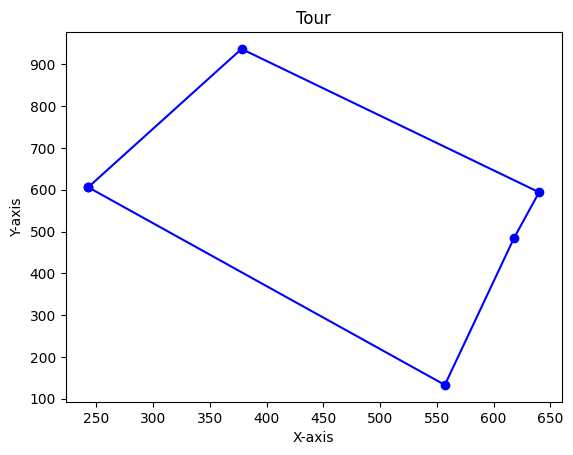

In [7]:
country.plot_tour(all_tours[0])



Try this algorithm on countries with 4, 6, 8, and 10 cities and plot the time it takes to calculate the answer.

[2.6599999955578824e-05, 0.0005029000000149608, 0.030999899999983427, 2.2942096999998967]


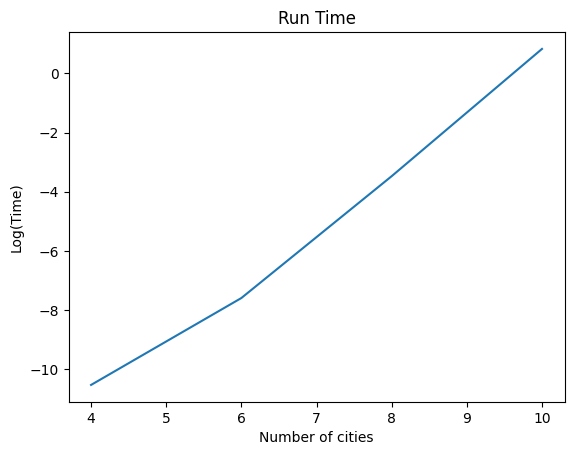

In [8]:
# creates different countries
# runs the algorithm and considers its run time
# plots the run times accordingly

countries = [TSP(i) for i in range(4, 11, 2)]
runtimes = []
for country in countries:
    start = timer()
    alltours_tsp(country)
    runtimes.append(timer() - start)
print(runtimes)
plt.plot(range(4, 11, 2), np.log(runtimes))
plt.xlabel('Number of cities')
plt.ylabel('Log(Time)')
plt.title('Run Time')
plt.show()

## local Algorithms

### Initial Functions (25 Points)

We will create some functions for our initial state and use these functions for our local algorithms later.

- random initial function: Create a feasible tour randomly.

In [9]:
def random_initial(tsp):
    # creates a random tour and returns tour, length
    random_tour = random.sample(range(tsp.num_cities), tsp.num_cities)
    return random_tour, tsp.tour_length(random_tour)

- nearest neighbor initial function: Start at any city; at each step, extend the tour by moving from the previous city to its nearest neighbor that has yet to be visited.

In [10]:
def nearest_neighbor_initial(tsp):
    # creates a nearest neighbor tour as above and returns tour, length
    tour = [random.randint(0, tsp.num_cities-1)]
    cities = [city for city in range(tsp.num_cities)]
    cities.remove(tour[0])
    while len(cities) > 0:
        tour.append(tsp.nearest_neighbor(tour[-1], cities))
        cities.remove(tour[-1])
    return tour, tsp.tour_length(tour)

- repeated nearest neighbor initial function : You can improve nearest neighbor algorithm by running it multiple times with different starting cities and using the best-generated answer.

In [11]:
def repeated_nearest_neighbor_initial(tsp, repetitions = None):
    # repeats nearest_neighbor_initial for better performance
    # if repetitions == None --> repetition = tsp.city_num
    if repetitions is None:
        repetitions = tsp.num_cities
    best_tour, best_length = nearest_neighbor_initial(tsp)
    for _ in range(repetitions-1):
        tour, length = nearest_neighbor_initial(tsp)
        if length < best_length:
            best_tour, best_length = tour, length
    return best_tour, best_length

Now, try to create a country with 30 cities, apply your repeated_nearest_neighbor_initial function with repetitions of 1, 4, 8, 12, and compare the results.

[6377.996896021232, 5347.367592811488, 5347.367592811488, 5460.385277118495]


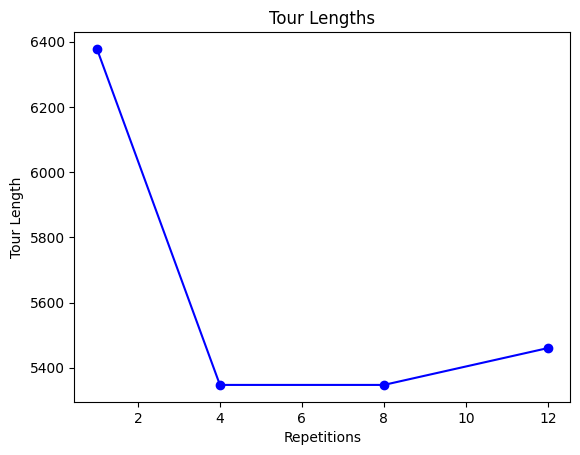

In [12]:
country = TSP(30)
tours, tour_lengths = [], []
for repetition in [1, 4, 8, 12]:
    tour, tour_length = repeated_nearest_neighbor_initial(country, repetition)
    tours.append(tour)
    tour_lengths.append(tour_length)
print(tour_lengths)
plt.plot([1, 4, 8, 12], tour_lengths, color='blue', marker='o')
plt.ylabel('Tour Length')
plt.xlabel('Repetitions')
plt.title('Tour Lengths')
plt.show()

Does repetition make our answer optimal? YES; because the nearest neighbor algorithm is not optimal and it is sensitive to the starting point. By repeating the algorithm, we can find a better starting point and improve our answer, But it is not guaranteed to be the optimal answer.

- beam search initial function: Start with a list of n cities; at each step, extend your semi-tours by moving from their previous cities to their n nearest neighbors and then pick out n semi-tours from these generated semi-tours of length i+1

In [13]:
def beam_search_initial(tsp, n, iter):
    # initials n starting points and name it as queue
    queue = [[i] for i in random.sample(range(tsp.num_cities), n)]

    # in every iter : (iter range could not be less than tsp.city_num)
    # uses the queue elements to create n new elements from each (new elements contain more cities)
    # filters these n^2 elements and just use n of them and name them as queue
    if iter < tsp.num_cities:
        raise Exception('iter could not be less than tsp.num_cities')
    else:
        for _ in range(tsp.num_cities-1):
            expanded = []
            for element in queue:
                if len(element) < tsp.num_cities:
                    for i in range(tsp.num_cities):
                        if i not in element:
                            expanded.append(element + [i])
                else:
                    break
            expanded.sort(key=lambda x : tsp.tour_length(x))
            for i in range(n):
                queue[i] = expanded[i]
    # returns tour, length of the best option in queue
    return queue[0], tsp.tour_length(queue[0])

Now, try to create a country with 30 cities, apply these initial functions, and compare the tour length of these initial tours with each other and the optimal answer (if city_num is low).

In [14]:
country = TSP(30)
random_tour, random_tour_length = random_initial(country)
nn_tour, nn_tour_length = nearest_neighbor_initial(country)
rnn_tour, rnn_tour_length = repeated_nearest_neighbor_initial(country, 10)
bsi_tour, bsi_tour_length = beam_search_initial(country, 5, 100)

Plot these tours and compare them visually.

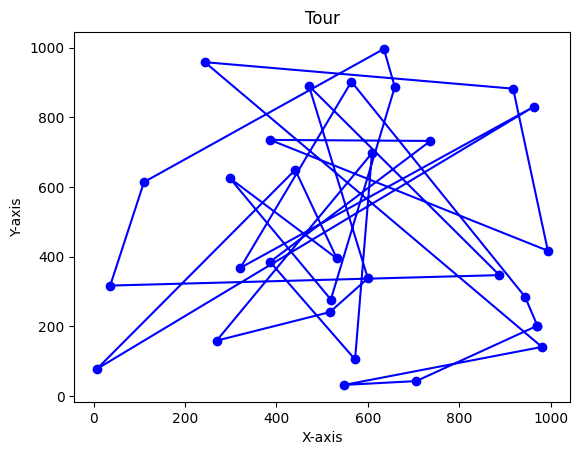

15580.778917284788


In [15]:
# plots the tours accordingly (random)
country.plot_tour(random_tour)
print(random_tour_length)

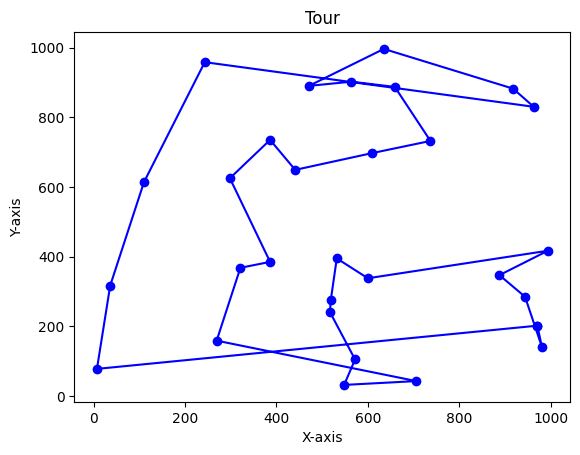

6540.512090472364


In [16]:
# plots the tours accordingly (nn)
country.plot_tour(nn_tour)
print(nn_tour_length)

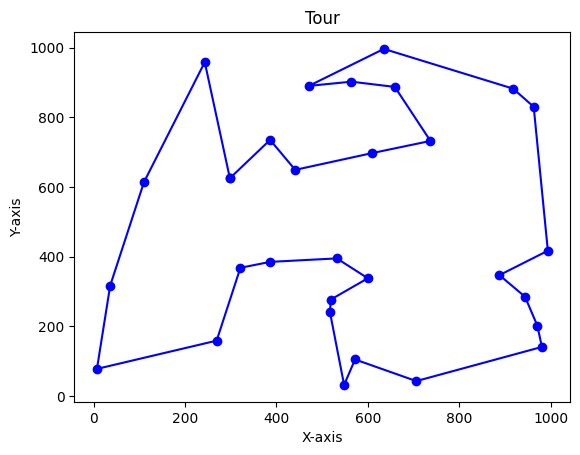

5167.01243205011


In [17]:
# plots the tours accordingly (rnn)
country.plot_tour(rnn_tour)
print(rnn_tour_length)

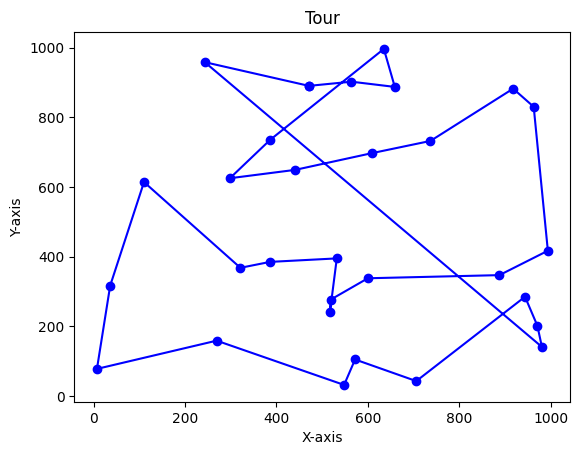

6398.0724019362315


In [18]:
# plots the tours accordingly (beam)
country.plot_tour(bsi_tour)
print(bsi_tour_length)

### LKH (25 Points)

Implement a simplified version of [LKH](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwimj7nFoqCEAxWzh_0HHc98Df4QFnoECCQQAQ&url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FLin%25E2%2580%2593Kernighan_heuristic&usg=AOvVaw0G05-wkkun1YAp6zPfWuLd&opi=89978449) for this problem.</br>
- This local search algorithm takes the initial state and improves it over time by swapping a part of the tour sequence.
- In this modified version, we will check every (i,j) pair at each iteration and reverse the tour from index "I" to index "J" if it improves our tour.


In [19]:
def lin_kernighan(tsp, initial, iterations=10):
    tour = initial
    for _ in range(iterations):
        for i in range(tsp.num_cities):
            for j in range(i+1, tsp.num_cities):
                reversed_sub_array = [tour[x] for x in range(j, i-1, -1)]
                new_tour = tour[:i] + reversed_sub_array + tour[j+1:]
                if tsp.tour_length(new_tour) < tsp.tour_length(tour):
                    tour = new_tour
    return tour, tsp.tour_length(tour)

Run this algorithm on a reasonably big country and visualize it.</br>
You can use any initial state in this part.

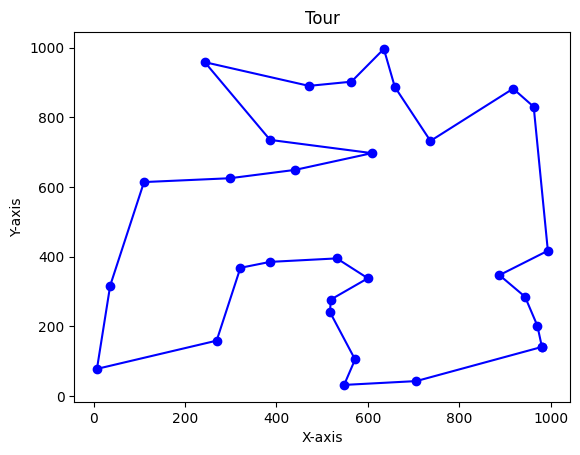

4961.492855898447


In [20]:
tour, tour_length = lin_kernighan(country, random_tour)
country.plot_tour(tour)
print(tour_length)

### Simulated Annealing (25 Points)

Implement simulated annealing for this problem.

In [21]:
def simulated_annealing(tsp, initial, initial_temperature=1000, cooling_rate=0.99, num_iterations=10000):
    tour, best_tour = initial, initial
    for _ in range(num_iterations):
        random_city1 = random.randint(0, tsp.num_cities-1)
        random_city2 = random.randint(random_city1, tsp.num_cities-1)
        new_tour = tour[:random_city1] + [tour[x] for x in range(random_city2, random_city1-1, -1)] + tour[random_city2+1:]
        if tsp.tour_length(new_tour) < tsp.tour_length(tour) or random.uniform(0, 1) < math.exp(-abs(tsp.tour_length(new_tour) - tsp.tour_length(tour)) / initial_temperature):
            tour = new_tour
            if tsp.tour_length(tour) < tsp.tour_length(best_tour):
                best_tour = tour
        initial_temperature *= cooling_rate
            
    return best_tour, tsp.tour_length(best_tour)

Run this algorithm on a reasonably big country and visualize it.</br>
You can use any initial state in this part.

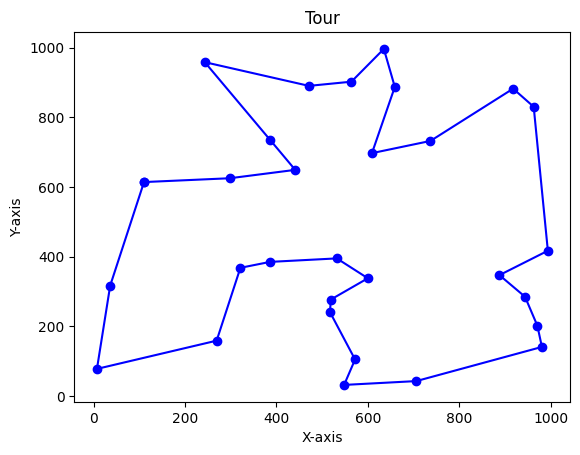

4818.287300887992


In [22]:
tour, tour_length = simulated_annealing(country, random_tour)
country.plot_tour(tour)
print(tour_length)

### Analysis

- The given code can calculate an acceptable approximated answer.
- use this code to compare your algorithms.

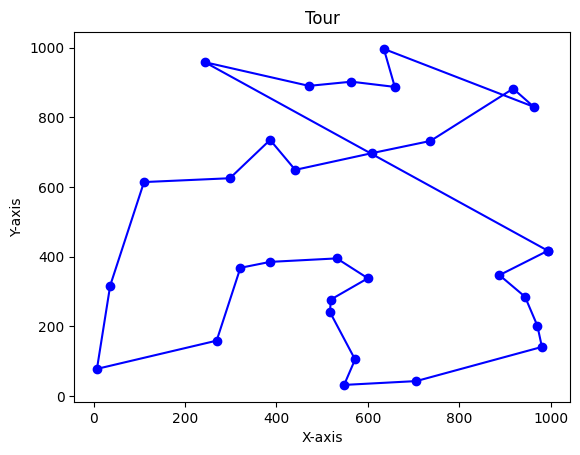

5384.89807848567


In [23]:
path = solve_tsp(country.distances)
country.plot_tour(path)
print(country.tour_length(path))

- analyze the lengths you get from the two algorithms with different initial functions
- plot these tours and explain the results (results may be inconsistent as they are approximations)

Threshold: 5384.89807848567


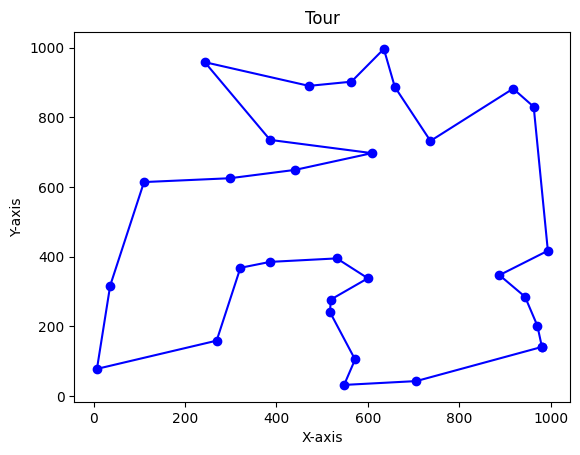

LKH ri: 4961.492855898447


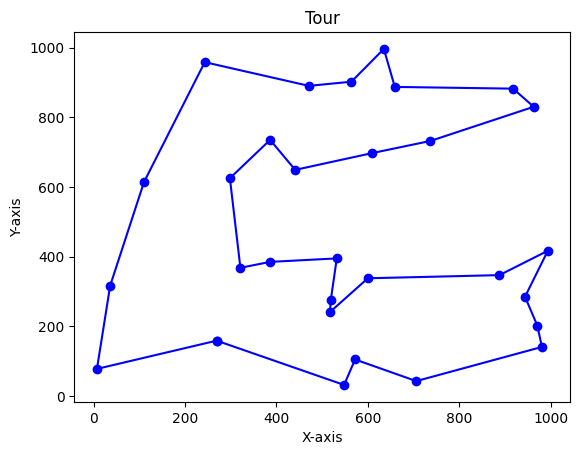

LKH nn: 5157.895721422821


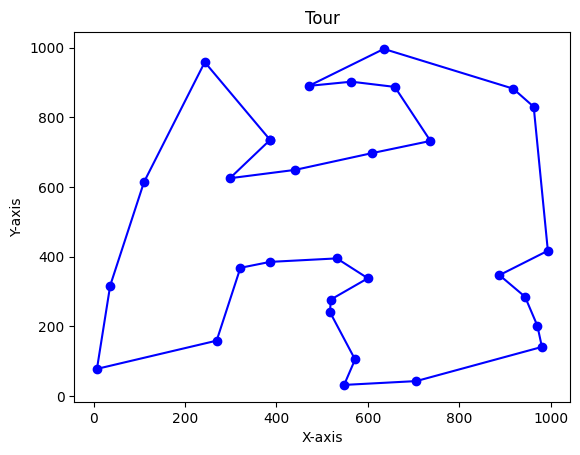

LKH rnn: 5083.477014888545


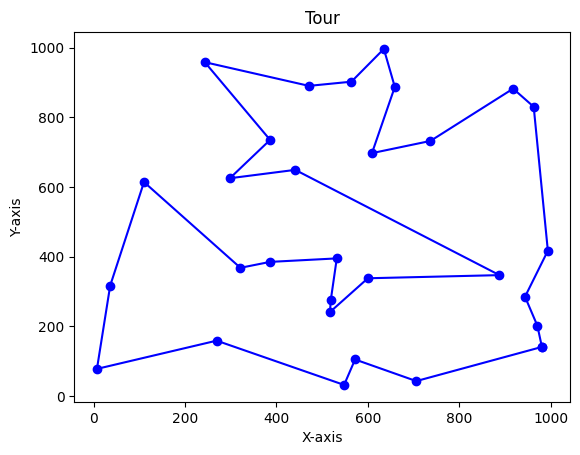

LKH bsi: 5741.006910523053


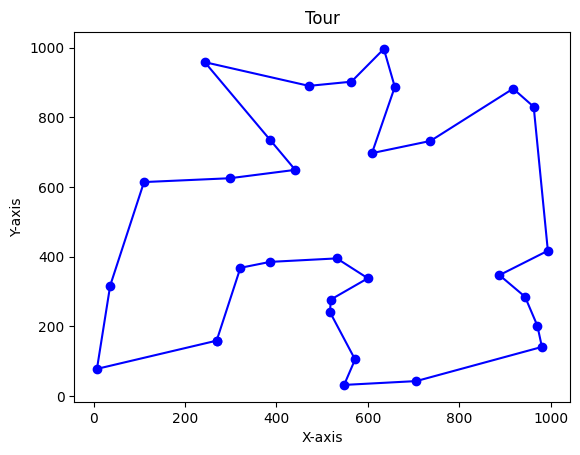

Simulated Annealing ri: 4818.2873008879915


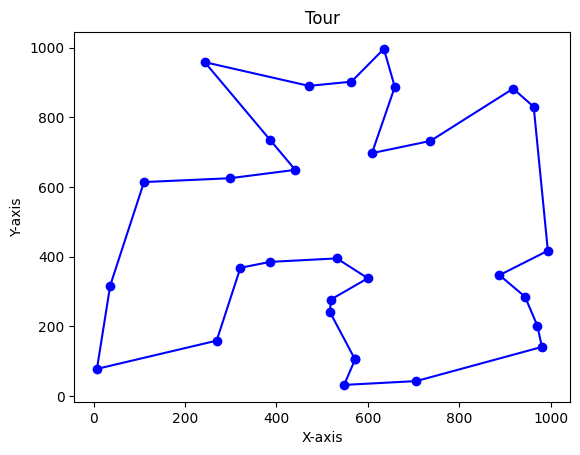

Simulated Annealing nn: 4818.2873008879915


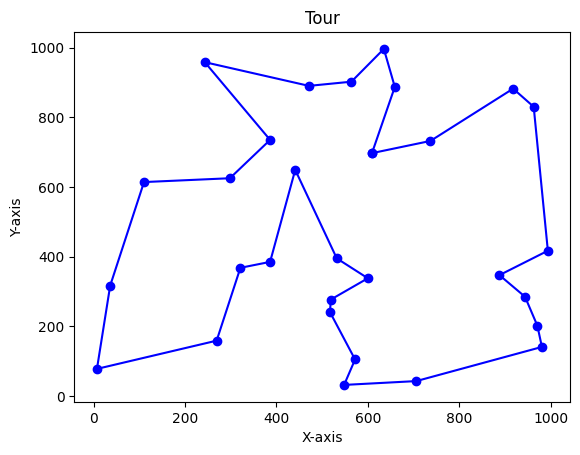

Simulated Annealing rnn: 5105.208176376758


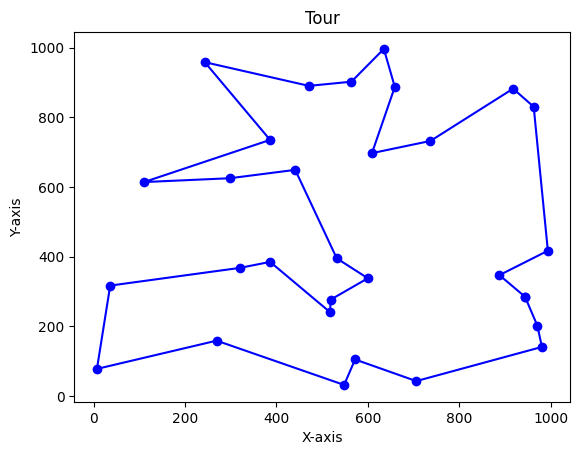

Simulated Annealing bsi: 5252.887284260584


In [24]:
different_initials = ['LKH ri', 'LKH nn', 'LKH rnn', 'LKH bsi', 'Simulated Annealing ri', 'Simulated Annealing nn', 'Simulated Annealing rnn', 'Simulated Annealing bsi']
algorithm_dictionary = {}
for i in range(7):
    algorithm_dictionary[different_initials[0]] = lin_kernighan(country, random_tour, 100)
    algorithm_dictionary[different_initials[1]] = lin_kernighan(country, nn_tour, 100)
    algorithm_dictionary[different_initials[2]] = lin_kernighan(country, rnn_tour, 100)
    algorithm_dictionary[different_initials[3]] = lin_kernighan(country, bsi_tour, 100)
    algorithm_dictionary[different_initials[4]] = simulated_annealing(country, random_tour)
    algorithm_dictionary[different_initials[5]] = simulated_annealing(country, nn_tour)
    algorithm_dictionary[different_initials[6]] = simulated_annealing(country, rnn_tour)
    algorithm_dictionary[different_initials[7]] = simulated_annealing(country, bsi_tour)
path_length = country.tour_length(path)
print(f'Threshold: {path_length}')
for algorithm in algorithm_dictionary:
    country.plot_tour(algorithm_dictionary[algorithm][0])
    print(f'{algorithm}: {algorithm_dictionary[algorithm][1]}')